# Теория для лабораторной 4


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam

## Сигнал и шум

При передаче или записи звука всегда добавляется шум - случайные колебания, не несущие полезной информации.

Классические методы фильтрации (из лаб. № 3) убирают шум через **цифровые фильтры** - например, фильтр Баттерворта.

## Автоэнкодер (autoencoder)

Это тип нейронной сети, которая **обучается восстанавливать исходные данные**, сжимая и затем восстанавливая их обратно

* Вход: зашумленный сигнал
* Выход: очищенный сигнал
* Задача: минимизировать ошибку между исходным и восстановленным звуком

Здесь используется **1D CNN (autoencoder)** - одномерная сверточная нейросеть, которая анализирует временные последовательности (в отличие от 2D для изображений).

## Сверточные слои (Conv1D)

Извлекают локальные закономерности - например, форму волны на коротком участке.

Они действуют как обучаемые фильтры, которые "понимают", какие частоты и особенности в сигнале полезные, а какие - шум.

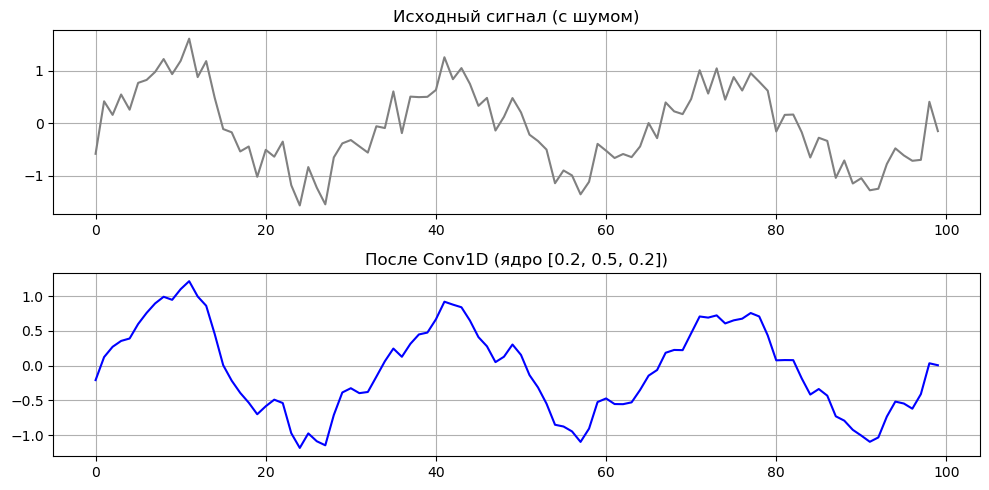

In [18]:
# Генерация сигнала
x = np.sin(2 * np.pi * 3 * np.linspace(0, 1, 100)) + np.random.randn(100) * 0.3
x = x.reshape(1, 100, 1)  # форма (batch, length, channels)

# Создаем модель
model = Sequential([
    Conv1D(filters=1, kernel_size=3, strides=1, padding='same', use_bias=False, input_shape=(100, 1))
])

# Принудительно строим модель (создаем веса)
model.build(input_shape=(None, 100, 1))

# Устанавливаем веса вручную
weights = np.array([[[0.2]], [[0.5]], [[0.2]]])  # (kernel_size, input_channels, filters)
model.layers[0].set_weights([weights])

# Применяем Conv1D
y = model.predict(x, verbose=0)[0, :, 0]



fig, ax = plt.subplots(2, 1, figsize=(10, 5))

ax[0].plot(x.flatten(), color="gray")
ax[0].set_title("Исходный сигнал (с шумом)")
ax[0].grid(True)

ax[1].plot(y, color="blue")
ax[1].set_title("После Conv1D (ядро [0.2, 0.5, 0.2])")
ax[1].grid(True)

fig.tight_layout()
plt.show()

## MaxPooling / UpSampling

* `MaxPooling1D` - уменьшает размерность, оставляя только "основные" признаки
* `UpSampling1D` - восстанавливает сигнал обратно к исходной длине

Вместе они образуют архитектуру кодировщика и декодировщика - autoencoder

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


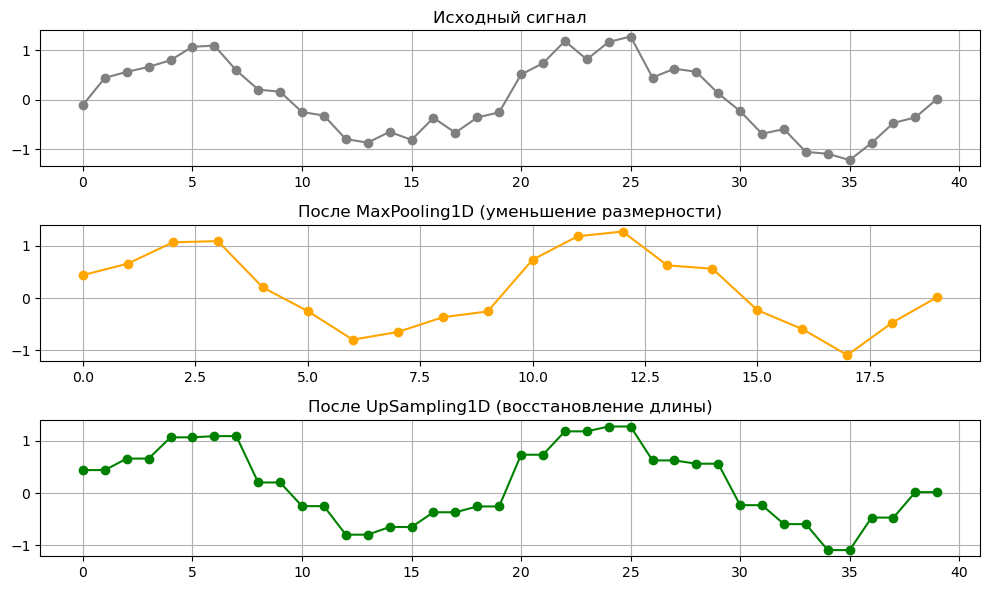

In [19]:
# Создаем сигнал
x = np.sin(2 * np.pi * 2 * np.linspace(0, 1, 40)) + np.random.randn(40) * 0.2
x = x.reshape(1, 40, 1)  # (batch, length, channels)

# MaxPooling и UpSampling
pool_model = Sequential([MaxPooling1D(pool_size=2, padding='valid', input_shape=(40, 1))])
upsample_model = Sequential([UpSampling1D(size=2, input_shape=(20, 1))])

# Применяем слои
pooled = pool_model.predict(x)
upsampled = upsample_model.predict(pooled)



fig, ax = plt.subplots(3, 1, figsize=(10, 6))

ax[0].plot(x.flatten(), "-o", color="gray")
ax[0].set_title("Исходный сигнал")
ax[0].grid(True)

ax[1].plot(pooled.flatten(), "-o", color="orange")
ax[1].set_title("После MaxPooling1D (уменьшение размерности)")
ax[1].grid(True)

ax[2].plot(upsampled.flatten(), "-o", color="green")
ax[2].set_title("После UpSampling1D (восстановление длины)")
ax[2].grid(True)

fig.tight_layout()
plt.show()

### Архитектура сети (в лабораторной)

Используется **автоэнкодер** на базе **одномерных сверточных слоев (Conv1D)**, состоящий из двух частей:

* **Encoder** - уменьшает размерность данных, выделяет наиболее важные признаки сигнала (аналог фильтрации)
* **Decoder** - восстанавливает исходную форму сигнала из полученных признаков

Архитектура модели (по коду):

```
Input -> Conv1D -> MaxPooling1D -> Conv1D -> MaxPooling1D -> 
UpSampling1D -> Conv1D -> UpSampling1D -> Conv1D -> Output
```

Также используются:

* `ZeroPadding1D` - для компенсации краевых эффектов при свертке,
* `Cropping1D` - для выравнивания длины сигнала после обработки.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


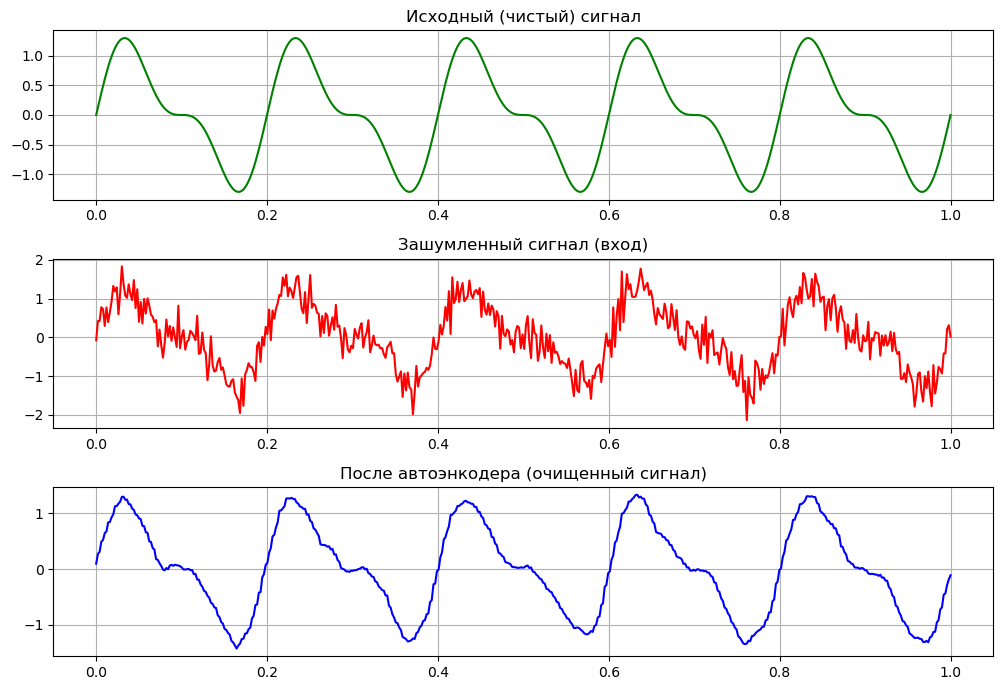

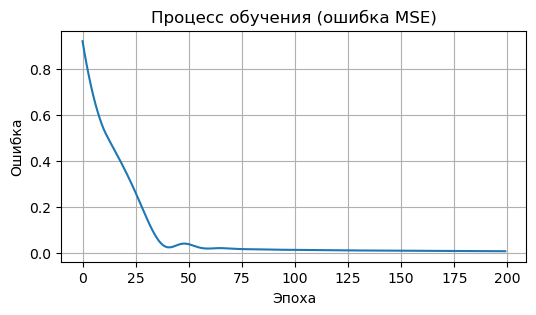

In [20]:
# Создаем сигнал
fs = 500
t = np.linspace(0, 1, fs)
clean = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)
noisy = clean + np.random.normal(0, 0.3, len(t))

# Формируем обучающую выборку (1 сигнал = 1 образец)
x_train = noisy.reshape(1, fs, 1)
y_train = clean.reshape(1, fs, 1)

# Модель автоэнкодера
model = Sequential([
    Conv1D(16, 3, activation='relu', padding='same', input_shape=(fs, 1)),
    MaxPooling1D(2, padding='same'),
    Conv1D(8, 3, activation='relu', padding='same'),
    MaxPooling1D(2, padding='same'),
    Conv1D(8, 3, activation='relu', padding='same'),
    UpSampling1D(2),
    Conv1D(16, 3, activation='relu', padding='same'),
    UpSampling1D(2),
    Conv1D(1, 3, activation='linear', padding='same')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Обучение (несколько эпох для демонстрации)
history = model.fit(x_train, y_train, epochs=200, verbose=0)

# Восстановленный сигнал
denoised = model.predict(x_train)[0, :, 0]



fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(t, clean, color="green")
ax[0].set_title("Исходный (чистый) сигнал")
ax[0].grid(True)

ax[1].plot(t, noisy, color="red")
ax[1].set_title("Зашумленный сигнал (вход)")
ax[1].grid(True)

ax[2].plot(t, denoised, color="blue")
ax[2].set_title("После автоэнкодера (очищенный сигнал)")
ax[2].grid(True)

fig.tight_layout()
plt.show()

# История обучения
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'])
plt.title("Процесс обучения (ошибка MSE)")
plt.xlabel("Эпоха")
plt.ylabel("Ошибка")
plt.grid(True)
plt.show()


x_train shape: (100, 500, 1)
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5683  
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3475
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1024 
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309 
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0181
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

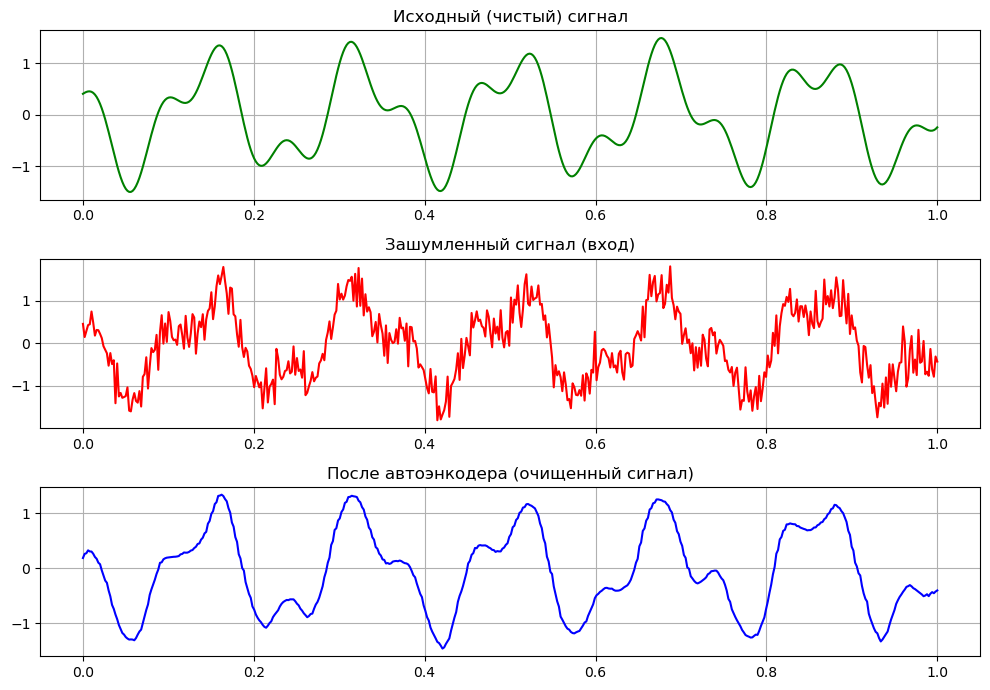

In [24]:
fs = 500
t = np.linspace(0, 1, fs)
n_samples = 100  # количество сигналов

x_train = []
y_train = []

# Генерация разных сигналов
for _ in range(n_samples):
    f1 = np.random.uniform(3, 8)   # частота 1
    f2 = np.random.uniform(8, 15)  # частота 2
    phase = np.random.uniform(0, np.pi)
    clean = np.sin(2*np.pi*f1*t + phase) + 0.5*np.sin(2*np.pi*f2*t)
    noisy = clean + np.random.normal(0, 0.3, len(t))

    x_train.append(noisy)
    y_train.append(clean)

# Преобразуем в 3D-массивы для Keras
x_train = np.array(x_train)[..., np.newaxis]  # (n_samples, fs, 1)
y_train = np.array(y_train)[..., np.newaxis]

print("x_train shape:", x_train.shape)

# Модель автоэнкодера
model = Sequential([
    Conv1D(16, 3, activation='relu', padding='same', input_shape=(fs, 1)),
    MaxPooling1D(2, padding='same'),
    Conv1D(8, 3, activation='relu', padding='same'),
    MaxPooling1D(2, padding='same'),
    Conv1D(8, 3, activation='relu', padding='same'),
    UpSampling1D(2),
    Conv1D(16, 3, activation='relu', padding='same'),
    UpSampling1D(2),
    Conv1D(1, 3, activation='linear', padding='same')
])

model.compile(optimizer=Adam(1e-3), loss='mse')

# Обучение
history = model.fit(x_train, y_train, epochs=50, batch_size=8, verbose=1)

# Проверим результат на одном примере
denoised = model.predict(x_train[:1])[0, :, 0]

fig, ax = plt.subplots(3, 1, figsize=(10, 7))
ax[0].plot(t, y_train[0, :, 0], color="green")
ax[0].set_title("Исходный (чистый) сигнал")
ax[1].plot(t, x_train[0, :, 0], color="red")
ax[1].set_title("Зашумленный сигнал (вход)")
ax[2].plot(t, denoised, color="blue")
ax[2].set_title("После автоэнкодера (очищенный сигнал)")
for a in ax: a.grid(True)
fig.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


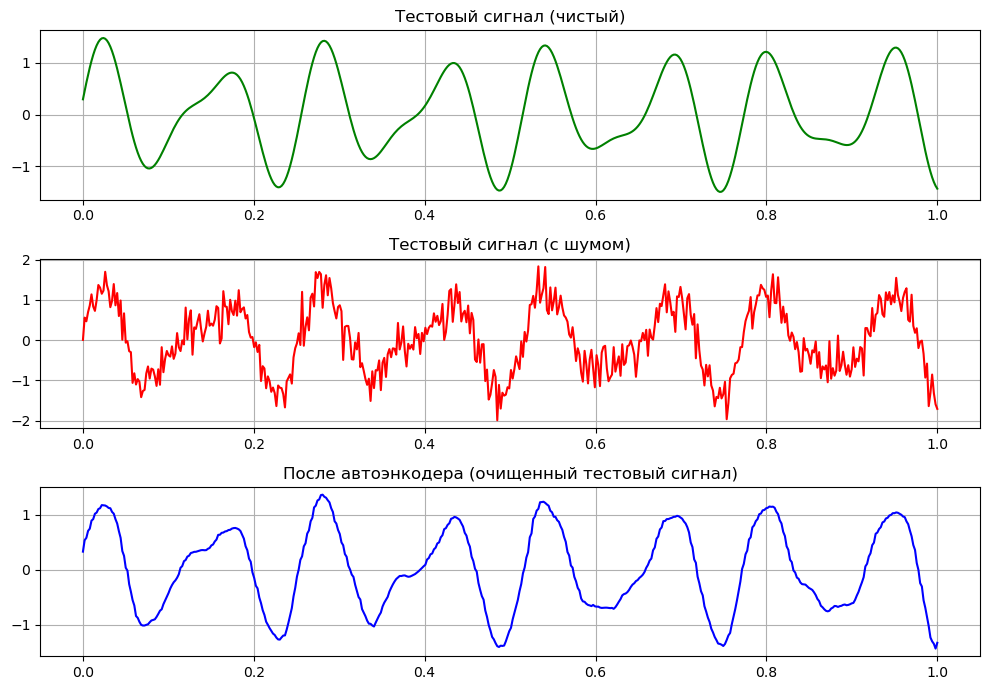

In [25]:
# Проверка на новом сигнале (не из обучения)
f1_test = np.random.uniform(3, 8)
f2_test = np.random.uniform(8, 15)
phase_test = np.random.uniform(0, np.pi)

clean_test = np.sin(2 * np.pi * f1_test * t + phase_test) + 0.5 * np.sin(2 * np.pi * f2_test * t)
noisy_test = clean_test + np.random.normal(0, 0.3, len(t))

x_test = noisy_test.reshape(1, fs, 1)
y_pred = model.predict(x_test)[0, :, 0]

# Визуализация результата
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

ax[0].plot(t, clean_test, color="green")
ax[0].set_title("Тестовый сигнал (чистый)")
ax[0].grid(True)

ax[1].plot(t, noisy_test, color="red")
ax[1].set_title("Тестовый сигнал (с шумом)")
ax[1].grid(True)

ax[2].plot(t, y_pred, color="blue")
ax[2].set_title("После автоэнкодера (очищенный тестовый сигнал)")
ax[2].grid(True)

fig.tight_layout()
plt.show()
